In [1]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

In [2]:
tf.__version__

'2.3.0'

In [3]:
driverlist = pd.read_csv('driver_imgs_list.csv')

In [4]:
driverlist

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [5]:
by_drivers = driverlist.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [6]:
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [7]:
img_rows = 64
img_cols = 64
color_type = 1

In [8]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:08<01:20,  8.95s/it]

Loading directory c1


 20%|██        | 2/10 [00:16<01:09,  8.65s/it]

Loading directory c2


 30%|███       | 3/10 [00:25<01:00,  8.57s/it]

Loading directory c3


 40%|████      | 4/10 [00:33<00:50,  8.42s/it]

Loading directory c4


 50%|█████     | 5/10 [00:40<00:40,  8.04s/it]

Loading directory c5


 60%|██████    | 6/10 [00:47<00:31,  7.84s/it]

Loading directory c6


 70%|███████   | 7/10 [00:57<00:24,  8.29s/it]

Loading directory c7


 80%|████████  | 8/10 [01:04<00:16,  8.01s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:11<00:07,  7.63s/it]

Loading directory c9


100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


Data Loaded in 78.45719504356384 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [9]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:00<05:09, 256.77it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


In [10]:
names = [item[17:19] for item in sorted(glob("imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('imgs', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


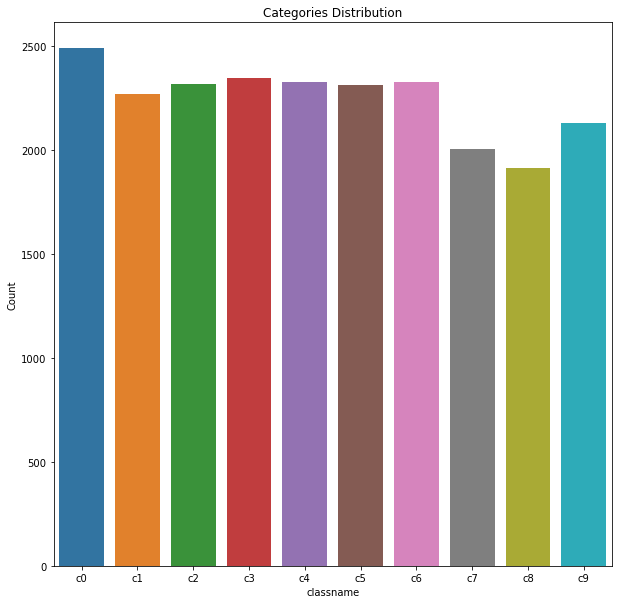

In [11]:
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = driverlist)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [12]:
drivers_id = pd.DataFrame((driverlist['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

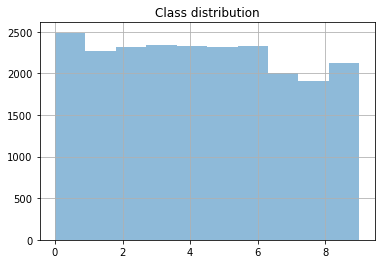

In [13]:
driverlist['class_type'] = driverlist['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
driverlist.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [14]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

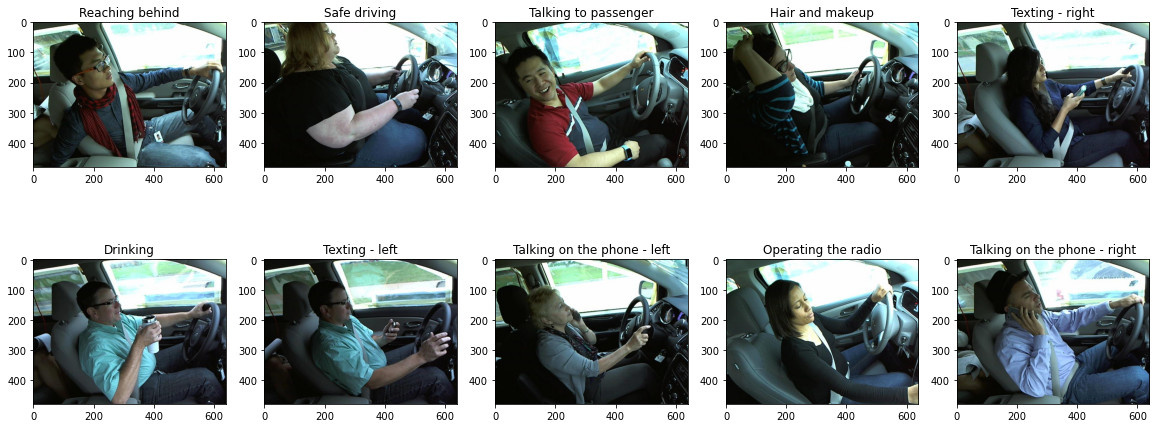

In [20]:
plt.figure(figsize = (20, 8))
image_count = 1
BASE_URL = 'imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(2, 5, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [34]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

In [35]:
batch_size = 40
nb_epoch = 10

In [44]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [45]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [46]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [47]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 512)        

In [48]:
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [50]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 31, 64)       

In [51]:
history_v2 = model_v2.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.3182 - accuracy: 0.5717
Epoch 00001: val_loss improved from inf to 0.50175, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 278s 620ms/step - loss: 1.3182 - accuracy: 0.5717 - val_loss: 0.5017 - val_accuracy: 0.8366
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8849
Epoch 00002: val_loss improved from 0.50175 to 0.16875, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 268s 598ms/step - loss: 0.3607 - accuracy: 0.8849 - val_loss: 0.1687 - val_accuracy: 0.9561
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9340
Epoch 00003: val_loss improved from 0.16875 to 0.11961, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 271s 605ms/step - loss: 0.2180 - accuracy: 0.9340 - val_loss: 0.1196 -

In [57]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

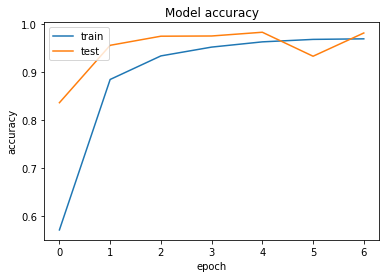

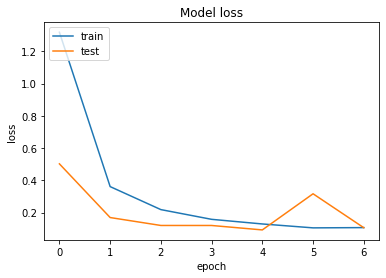

In [58]:
plot_train_history(history_v2)

In [59]:
model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')

In [60]:
score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)

141/141 [==============================] - 15s 109ms/step - loss: 0.0920 - accuracy: 0.9833
Score:  [0.09199955314397812, 0.9832776188850403]
113/113 [==============================] - 15s 128ms/step
Score log loss: 0.0919995422157656


In [62]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

1/1 [==============================] - 0s 680us/step
Y prediction: [[1.2234596e-16 1.3750500e-13 8.5342583e-23 1.0000000e+00 7.0008722e-20
  8.8954104e-15 1.0852256e-21 1.3303361e-21 2.3869891e-16 2.3950603e-13]]
Predicted: Texting - left


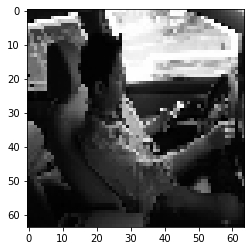

In [71]:
plot_test_class(model_v2, test_files, 143) 

In [72]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [73]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [74]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

17939
4485


In [75]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
448/448 [==============================] - 258s 576ms/step - loss: 1.2209 - accuracy: 0.6314 - val_loss: 4.5213 - val_accuracy: 0.1440
Epoch 2/5
448/448 [==============================] - 262s 585ms/step - loss: 0.6652 - accuracy: 0.7828 - val_loss: 0.3539 - val_accuracy: 0.9058
Epoch 3/5
448/448 [==============================] - 2462s 5s/step - loss: 0.5376 - accuracy: 0.8285 - val_loss: 0.2212 - val_accuracy: 0.9580
Epoch 4/5
448/448 [==============================] - 392s 876ms/step - loss: 0.4271 - accuracy: 0.8641 - val_loss: 0.1857 - val_accuracy: 0.9569
Epoch 5/5
448/448 [==============================] - 2266s 5s/step - loss: 0.3903 - accuracy: 0.8806 - val_loss: 0.2178 - val_accuracy: 0.9560


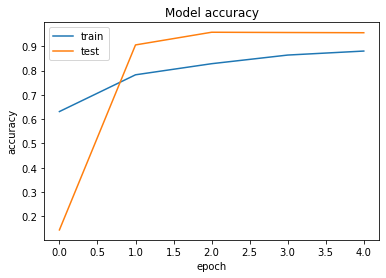

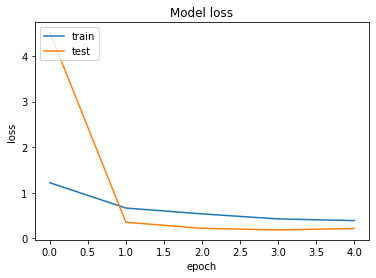

In [77]:
plot_train_history(history_v3)

In [80]:
# Evaluate the performance of the new model
score = model_v2.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2177572101354599
Test Accuracy: 0.9560267925262451


1/1 [==============================] - 0s 2ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


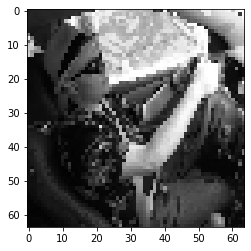

In [91]:
plot_test_class(model_v2, test_files, 2)

In [89]:
predictions = model_v2.predict(test_files, batch_size=batch_size)
FileLink(create_submission(predictions, test_targets, score[0]))

/Users/longmini/Kyeongho/MSIS/3rdQ_2020fall/MSIS2636/DLproject/kaggle_submissions/submission_0.2177572101354599_2020-11-19-13-32.csv